In [270]:
#Import Modules
import pandas as pd
import locale
from locale import atof
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
from pandas.plotting import scatter_matrix
#from datapackage import Package

In [2]:
income_clasification = []
#Read annual csv files and create DataFrames 
annual_files = ['2015-Annual.csv', '2016-Annual.csv', '2017-Annual.csv','2018-Annual.csv']

dfs = []
for file in annual_files:
    df = pd.read_csv(file, index_col=None, header=0)
    dfs.append(df)

big_frame = pd.concat(dfs, ignore_index=True)

#Rename columns State Name for State
big_frame =big_frame.rename(columns={"State Name":"State"})
big_frame.head()


,Edition,Report Type,Measure Name,State,Rank,Value,Score,Lower CI,Upper CI,Source,Source Year
0,2015,2015 Annual,Air Pollution,Alabama,34.0,9.5,0.00,NaN,NaN,U.S. Environmental Protection Agency; U.S. Cen...,2012-2014
1,2015,2015 Annual,Air Pollution,Alaska,4.0,6.0,-2.00,NaN,NaN,U.S. Environmental Protection Agency; U.S. Cen...,2012-2014
2,2015,2015 Annual,Air Pollution,Arizona,37.0,9.7,0.12,NaN,NaN,U.S. Environmental Protection Agency; U.S. Cen...,2012-2014
3,2015,2015 Annual,Air Pollution,Arkansas,37.0,9.7,0.12,NaN,NaN,U.S. Environmental Protection Agency; U.S. Cen...,2012-2014
4,2015,2015 Annual,Air Pollution,California,50.0,12.5,1.78,NaN,NaN,U.S. Environmental Protection Agency; U.S. Cen...,2012-2014


In [3]:
#Create the dateframe with specific columns
select_df = big_frame[['Edition','State','Measure Name','Rank','Value']]

#Delete all the rows that contain 'United States' and 'District of Columbia'
select_df = select_df[select_df.State != 'United States']
select_df = select_df[select_df.State != 'District of Columbia']

#Create a new dataframe that contains only the variables to be analyzed. This dataframe will be merged with the dataframe household income.
big_cleaned_unindexed=select_df.reset_index()
big_filtered_variables=big_cleaned_unindexed.set_index("Measure Name")  
sketch = big_filtered_variables.loc[["Cardiovascular Deaths","Diabetes","Heart Attack","High Blood Pressure","Obesity"]]

#This dataframe will be used for the histograms
select_df

,Edition,State,Measure Name,Rank,Value
0,2015,Alabama,Air Pollution,34.0,9.5
1,2015,Alaska,Air Pollution,4.0,6.0
2,2015,Arizona,Air Pollution,37.0,9.7
3,2015,Arkansas,Air Pollution,37.0,9.7
4,2015,California,Air Pollution,50.0,12.5
...,...,...,...,...,...
148875,2018,Vermont,Water Fluoridation,40.0,56.3
148876,2018,Washington,Water Fluoridation,33.0,63.9
148877,2018,Wisconsin,Water Fluoridation,16.0,88.9
148878,2018,West Virginia,Water Fluoridation,14.0,90.5


In [4]:
#Read other csv files and create DataFrames
other_files = ['Median Household Income.csv']

li = []
for file in other_files:
    df = pd.read_csv(file, index_col=None, header=0,thousands=',')
    li.append(df)
    
df_median_income = pd.DataFrame(li[0])

df_median_income.head()

,State,2018,2018.1,2017,2017.1,2016,2016.1,2015,2015.1
0,State,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror
1,United States,"63,179",420,"61,372",335,"59,039",436,"56,516",321
2,Alabama,"49,936","2,423","51,113",845,"47,221","2,301","44,509","3,419"
3,Alaska,"68,734","3,390","72,231","2,719","75,723","4,086","75,112","3,485"
4,Arizona,"62,283","2,291","61,125","2,642","57,100","1,971","52,248","2,008"


In [5]:
#Select 5 columns
df_median_income_reduced=df_median_income[['State','2018','2017','2016','2015']]
#df_median_income_reduced.head()

#Set State as index
income_index=df_median_income_reduced.set_index("State")
#income_index.head()

#Stacked pivot table, create dataframe and reset index
stacked=income_index.stack()
stacked_df=pd.DataFrame(stacked)
stacked_df_reset=stacked_df.reset_index()
stacked_df_index=stacked_df_reset.set_index("State")
stacked_rename =stacked_df_index .rename(columns={"level_1":"year",0:"income"})
stacked_rename.head()

,year,income
State,,
State,2018,Median\nincome
State,2017,Median\nincome
State,2016,Median\nincome
State,2015,Median\nincome
United States,2018,"63,179"


In [6]:
#This reset index is for checking later the unique values of State
stacked_del_reset=stacked_rename.reset_index()

#Delete rows that contain 'State', 'United Stated' and 'D.C.'
stacked_del_reset = stacked_del_reset[stacked_del_reset.State != 'United States']
stacked_del_reset = stacked_del_reset[stacked_del_reset.State != 'D.C.']
stacked_del_reset = stacked_del_reset[stacked_del_reset.State != 'State']

#Replace comma for nothing
stacked_del_reset['income']=stacked_del_reset['income'].str.replace(',','')
stacked_del_reset.head()

,State,year,income
8,Alabama,2018,49936
9,Alabama,2017,51113
10,Alabama,2016,47221
11,Alabama,2015,44509
12,Alaska,2018,68734


In [7]:
# Bins are of income 
bins = [0, 49999, 54999, 59999, 69999, 100000]

# Create the names for the five bins
group_names = ["Region 1", "Region 2", "Region 3", "Region 4", "Region 5"]

In [8]:
#Classification of median income household
stacked_del_reset["Income classification"] = pd.cut(stacked_del_reset["income"].astype(float), bins, labels=group_names)
stacked_del_reset.head()

,State,year,income,Income classification
8,Alabama,2018,49936,Region 1
9,Alabama,2017,51113,Region 2
10,Alabama,2016,47221,Region 1
11,Alabama,2015,44509,Region 1
12,Alaska,2018,68734,Region 4


In [9]:
#Create a unique id in order to merge both dataframes
sketch['id_search']=(sketch['Edition'].astype(str)).str.cat(sketch['State'],sep='-')
sketch_no_indexed=sketch.reset_index()
stacked_del_reset['id_search']=stacked_del_reset['year'].str.cat(stacked_del_reset['State'],sep='-')

#Merge both tables
result = pd.merge(sketch_no_indexed,stacked_del_reset, how='left', on='id_search')
result.head()


,Measure Name,index,Edition,State_x,Rank,Value,id_search,State_y,year,income,Income classification
0,Cardiovascular Deaths,1924,2015,Alabama,49.0,330.1,2015-Alabama,Alabama,2015,44509,Region 1
1,Cardiovascular Deaths,1925,2015,Alaska,8.0,214.9,2015-Alaska,Alaska,2015,75112,Region 5
2,Cardiovascular Deaths,1926,2015,Arizona,10.0,216.6,2015-Arizona,Arizona,2015,52248,Region 2
3,Cardiovascular Deaths,1927,2015,Arkansas,47.0,313.4,2015-Arkansas,Arkansas,2015,42798,Region 1
4,Cardiovascular Deaths,1928,2015,California,23.0,233.6,2015-California,California,2015,63636,Region 4


In [10]:
#Find any missing value in any of the columns
missing_values=pd.DataFrame(result.isnull().any(axis=1))

#Filter all the rows that contain a missing value. In this case, the boolean value TRUE is the one with missing values.
missing_true=pd.DataFrame(missing_values.loc[missing_values[0] == True])

#Obtain indexes and convert them into a list
missing_indexes=list(missing_true.index)

#Get and print the dataframe that contains all the rows with a missing value in any of the columns.
missing_result = pd.DataFrame(result.loc[missing_indexes])

In [ ]:
#Export missing values to Excel. (Note: If the data cleaning was done correctly, this file should be empty.)
missing_result.to_excel('missing_values.xlsx')


In [ ]:
#Export final dataframe
result.to_excel('result_dataframe.xlsx')

C:\Users\Adriana Lorena\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


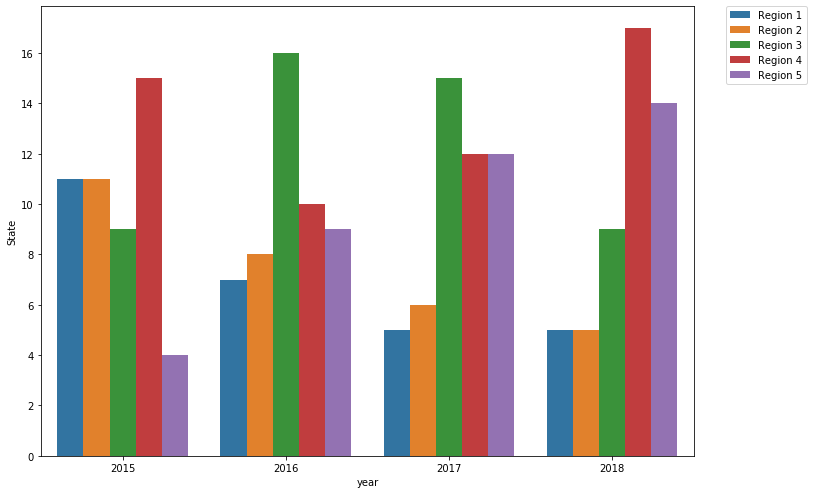

In [116]:
#Bar plots Household Income Classified

stacked_del_reset['year'].astype(str)
#Group by Income classification
income_group=stacked_del_reset.groupby(['year','Income classification'])

# Count how many times each region appears in our group
count_income=pd.DataFrame(income_group['State'].count())

income_reset=count_income.reset_index()

#count_income.set_index('year')
#Bar plot grouped by Income classification and year
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.barplot(x='year', y='State', hue='Income classification',data=income_reset,ax=ax)

#Put legend out of the figure
ax=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig("Median Household Income by Classification.png")
 
fig.show()



In [ ]:
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            ha="center")

In [39]:
#Create pivot table of household income variable

#Make for in order to convert values from string to int
stacked_del_reset['income_int']=stacked_del_reset["income"].astype(int)

income_pivot = pd.DataFrame(stacked_del_reset.pivot_table(values='income_int',index='State', columns='year'))
income_pivot_no_index = income_pivot.reset_index()
income_pivot_rename = income_pivot_no_index.rename(columns={"2015":"2015_income", "2016":"2016_income","2017":"2017_income","2018":"2018_income"})
income_pivot_rename.head()

year,State,2015_income,2016_income,2017_income,2018_income
0,Alabama,44509,47221,51113,49936
1,Alaska,75112,75723,72231,68734
2,Arizona,52248,57100,61125,62283
3,Arkansas,42798,45907,48829,49781
4,California,63636,66637,69759,70489


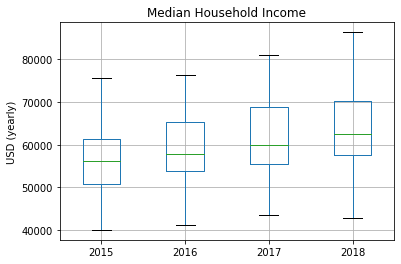

In [99]:
#Create boxplot (include the 4 years in the graph)

income_pivot_no_index.boxplot(column=["2015","2016","2017","2018"])
plt.title("Median Household Income")
plt.ylabel("USD (yearly)")
plt.savefig("Median Household Income boxplot.png")
plt.show()



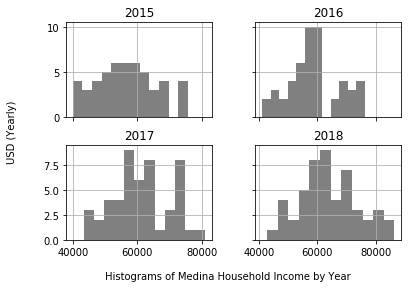

[[2015,
  NormaltestResult(statistic=1.6218584678151968, pvalue=0.44444488102631685)],
 [2016,
  NormaltestResult(statistic=0.8067778442317253, pvalue=0.6680522285058647)],
 [2017,
  NormaltestResult(statistic=1.129179339255823, pvalue=0.568593410042272)],
 [2018,
  NormaltestResult(statistic=0.9098187872374677, pvalue=0.6345054555870397)]]

In [240]:
#Create histogram per year of Household Income

#Cardiovascular dataframe
fig, ax = plt.subplots(nrows=2, ncols=2,sharex='col', sharey='row')

normality_income=[]

m=1
year=2015
for i in range(2):
    for j in range(2):
        income_pivot_no_index.hist(column = income_pivot_no_index.columns[m], bins = 12, ax=ax[i,j], figsize=(20, 18),color='gray')
        normality=st.normaltest(income_pivot_no_index.iloc[:,m])
        normality_income.append([year,normality])
        m+=1
        year+=1

#Put a general x_label and y_label
fig=ax[0,0].figure
fig.text(0.5,0, "Histograms of Medina Household Income by Year", ha="center", va="center")
fig.text(0,0.5, "USD (Yearly)", ha="center", va="center", rotation=90)

plt.savefig("Histogram Median Household Income.png")

plt.show()

normality_income

In [31]:
#Cardiovascular dataframe
c_df = pd.pivot_table(select_df,values='Value',index=['Measure Name','State'], columns='Edition', aggfunc='mean')
c1_df = c_df.loc['Cardiovascular Deaths']
c2_df = c1_df.reset_index()
#c2_df.head()

#Diabetes dataframe
d_df = pd.pivot_table(select_df,values='Value',index=['Measure Name','State'], columns='Edition', aggfunc='mean')
d1_df = d_df.loc['Diabetes']
d2_df = d1_df.reset_index()
#d2_df.head()

#Heart Attack dataframe
ha_df = pd.pivot_table(select_df,values='Value',index=['Measure Name','State'], columns='Edition', aggfunc='mean')
ha1_df = ha_df.loc['Heart Attack']
ha2_df = ha1_df.reset_index()
#ha2_df.head()

#Obesity dataframe
o_df = pd.pivot_table(select_df,values='Value',index=['Measure Name','State'], columns='Edition', aggfunc='mean')
o1_df = o_df.loc['Obesity']
o2_df = o1_df.reset_index()
#o2_df.head()

#High Blood Pressure dataframe
hbp_df = pd.pivot_table(select_df,values='Value',index=['Measure Name','State'], columns='Edition', aggfunc='mean')
hbp1_df = hbp_df.loc['High Blood Pressure']
hbp2_df = hbp1_df.reset_index()
#hbp2_df.head()

In [32]:
hbp2_df.head()

Edition,State,2015,2016,2017,2018
0,Alabama,40.3,40.4,40.4,41.9
1,Alaska,29.8,27.5,27.5,31.8
2,Arizona,30.7,30.8,30.8,30.7
3,Arkansas,38.7,39.3,39.3,41.3
4,California,28.7,28.5,28.5,28.4


In [54]:
#Create dataframe for the scatter plots by variable

#Cardiovascular deaths
result_c= pd.merge(c2_df,income_pivot_rename, how='left', on='State')
#result_hbp.head()

#Diabetes
result_d= pd.merge(d2_df,income_pivot_rename, how='left', on='State')
#result_hbp.head()

#Heart attack
result_ha= pd.merge(ha2_df,income_pivot_rename, how='left', on='State')
#result_hbp.head()

#Obesity
result_o= pd.merge(o2_df,income_pivot_rename, how='left', on='State')
#result_hbp.head()

#High blood pressure
result_hbp= pd.merge(hbp2_df,income_pivot_rename, how='left', on='State')
#result_hbp.head()

In [204]:
result_c

,State,2015,2016,2017,2018,2015_income,2016_income,2017_income,2018_income
0,Alabama,330.1,332.9,339.6,342.6,44509,47221,51113,49936
1,Alaska,214.9,214.1,222.2,226.1,75112,75723,72231,68734
2,Arizona,216.6,213.7,214.4,217.4,52248,57100,61125,62283
3,Arkansas,313.4,317.3,323.0,330.2,42798,45907,48829,49781
4,California,233.6,229.9,230.4,231.1,63636,66637,69759,70489
5,Colorado,196.2,199.3,203.0,207.4,66596,70566,74172,73034
6,Connecticut,217.5,217.2,218.4,217.9,72889,75923,72780,72812
7,Delaware,245.6,247.5,250.7,253.9,57756,58046,62318,65012
8,Florida,221.0,224.8,229.0,233.1,48825,51176,53681,54644
9,Georgia,269.8,272.9,278.1,282.9,50768,53527,57016,55821


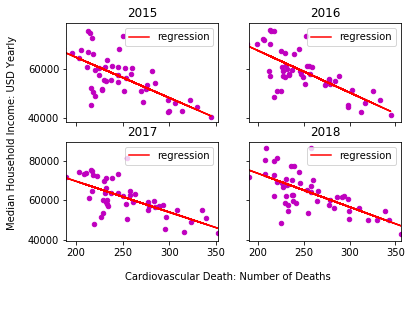

In [312]:
#Scatterplots of Household Income vs Variables

#Cardiovascular dataframe
fig, ax = plt.subplots(nrows=2, ncols=2,sharex='col', sharey='row')
c_corr=[]

m=1
n=5
o=0
p=1
year=2015


for i in range(2):
    for j in range(2):
        (slope, intercept, rvalue, pvalue, stderr) = linregress(result_c.iloc[:,m], result_c.iloc[:,n])
        regress_values = pd.DataFrame(result_c.iloc[:,m].astype(float) * slope + intercept)
        line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
        result_c.plot(x=result_c.columns[m], y=result_c.columns[n], kind="scatter",ax=ax[i,j],c='m')
        prueba= pd.DataFrame(result_c.iloc[:,m])
        prueba['regression']=regress_values
        prueba.plot(x=prueba.columns[0],y=prueba.columns[1],ax=ax[i,j],c='r')
        plt.annotate(line_eq,(6,10),fontsize=15,color="red")
        correlation = st.pearsonr(result_c.iloc[:,m],result_c.iloc[:,n])
        c_corr.append([year,correlation])
        m+=1
        n+=1
        year+=1

#Put a general x_label and y_label
fig=ax[0,0].figure
fig.text(0.5,0, "Cardiovascular Death: Number of Deaths", ha="center", va="center")
fig.text(0,0.5, "Median Household Income: USD Yearly", ha="center", va="center", rotation=90)

#Set labels
ax[0,0].set_title('2015')
ax[0,1].set_title('2016')
ax[1,1].set_title('2018')
ax[1,0].set_title('2017')


ax[0,0].set_ylabel(' ')
ax[1,1].set_xlabel(' ')
ax[1,0].set_ylabel(' ')
ax[1,0].set_xlabel(' ')

c_corr

plt.savefig("Median Household Income vs Cardiovascular Deaths.png")
#plt.show()


[[2015, (-0.7014586289779903, 1.3941697895601847e-08)],
 [2016, (-0.7702405690473335, 6.165883225556263e-11)],
 [2017, (-0.6556264450683881, 2.373259052095135e-07)],
 [2018, (-0.6175161192371444, 1.7797369233498003e-06)]]

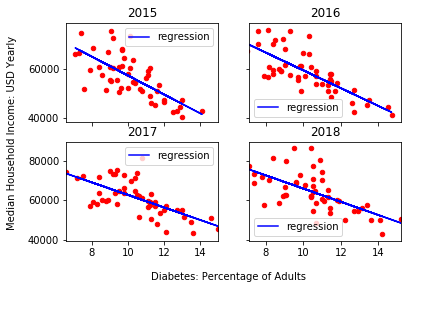

In [313]:
#Diabetes dataframe
fig, ax = plt.subplots(nrows=2, ncols=2,sharex='col', sharey='row')
d_corr=[]

m=1
n=5
year=2015

for i in range(2):
    for j in range(2):
        (slope, intercept, rvalue, pvalue, stderr) = linregress(result_d.iloc[:,m], result_d.iloc[:,n])
        regress_values = pd.DataFrame(result_d.iloc[:,m].astype(float) * slope + intercept)
        line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
        result_d.plot(x=result_d.columns[m], y=result_d.columns[n], kind="scatter",ax=ax[i,j],c='r')
        prueba= pd.DataFrame(result_d.iloc[:,m])
        prueba['regression']=regress_values
        prueba.plot(x=prueba.columns[0],y=prueba.columns[1],ax=ax[i,j],c='b')
        plt.annotate(line_eq,(6,10),fontsize=15,color="red")
        correlation = st.pearsonr(result_d.iloc[:,m],result_d.iloc[:,n])
        d_corr.append([year,correlation])
        m+=1
        n+=1
        year+=1

        
#Put a general x_label and y_label
fig=ax[0,0].figure
fig.text(0.5,0, "Diabetes: Percentage of Adults", ha="center", va="center")
fig.text(0,0.5, "Median Household Income: USD Yearly", ha="center", va="center", rotation=90)

#Set labels
ax[0,0].set_title('2015')
ax[0,1].set_title('2016')
ax[1,1].set_title('2018')
ax[1,0].set_title('2017')


ax[0,0].set_ylabel(' ')
ax[1,1].set_xlabel(' ')
ax[1,0].set_ylabel(' ')
ax[1,0].set_xlabel(' ')

plt.savefig("Median Household Income vs Diabetes.png")

d_corr
#plt.show()

[[2015, (-0.734017586434605, 1.3181113381447847e-09)],
 [2016, (-0.7911062313129955, 8.107644165135837e-12)],
 [2017, (-0.7425063581637046, 6.731714287184607e-10)],
 [2018, (-0.6608751775250776, 1.7582232757214764e-07)]]

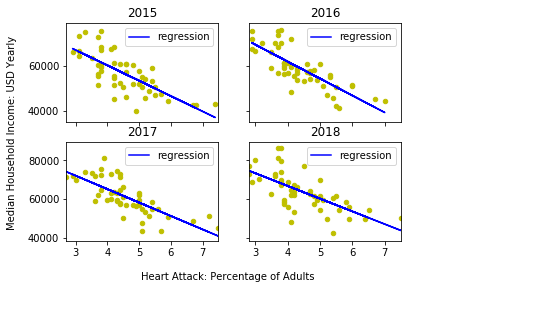

In [314]:
#Heart Attack dataframe
fig, ax = plt.subplots(nrows=2, ncols=2,sharex='col', sharey='row')
ha_corr=[]

m=1
n=5
year=2015

for i in range(2):
    for j in range(2):
        (slope, intercept, rvalue, pvalue, stderr) = linregress(result_ha.iloc[:,m], result_ha.iloc[:,n])
        regress_values = pd.DataFrame(result_ha.iloc[:,m].astype(float) * slope + intercept)
        line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
        result_ha.plot(x=result_ha.columns[m], y=result_ha.columns[n], kind="scatter",ax=ax[i,j],c='y')
        prueba= pd.DataFrame(result_ha.iloc[:,m])
        prueba['regression']=regress_values
        prueba.plot(x=prueba.columns[0],y=prueba.columns[1],ax=ax[i,j],c='b')
        plt.annotate(line_eq,(6,10),fontsize=15,color="red")
        correlation = st.pearsonr(result_ha.iloc[:,m],result_ha.iloc[:,n])
        ha_corr.append([year,correlation])
        m+=1
        n+=1
        year+=1

        
        
#Put a general x_label and y_label
fig=ax[0,0].figure
fig.text(0.5,0, "Heart Attack: Percentage of Adults", ha="center", va="center")
fig.text(0,0.5, "Median Household Income: USD Yearly", ha="center", va="center", rotation=90)

#Set labels
ax[0,0].set_title('2015')
ax[0,1].set_title('2016')
ax[1,1].set_title('2018')
ax[1,0].set_title('2017')


ax[0,0].set_ylabel(' ')
ax[1,1].set_xlabel(' ')
ax[1,0].set_ylabel(' ')
ax[1,0].set_xlabel(' ')

plt.savefig("Median Household Income vs Heart Attack.png")

ha_corr

#plt.show()

[[2015, (-0.618395854596098, 1.7039628615693529e-06)],
 [2016, (-0.7239084452196914, 2.8406469297105603e-09)],
 [2017, (-0.6754924645920051, 7.38642509970047e-08)],
 [2018, (-0.594017523099928, 5.426770550453926e-06)]]

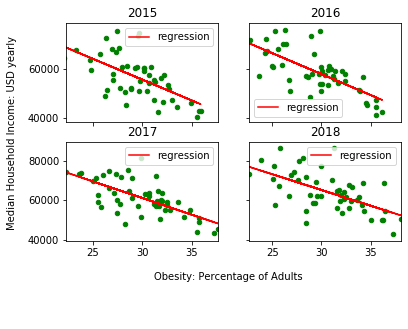

In [315]:
#Obesity dataframe
fig, ax = plt.subplots(nrows=2, ncols=2,sharex='col', sharey='row')
o_corr=[]

m=1
n=5
year=2015


for i in range(2):
    for j in range(2):
        (slope, intercept, rvalue, pvalue, stderr) = linregress(result_o.iloc[:,m], result_o.iloc[:,n])
        regress_values = pd.DataFrame(result_o.iloc[:,m].astype(float) * slope + intercept)
        line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
        result_o.plot(x=result_o.columns[m], y=result_o.columns[n], kind="scatter",ax=ax[i,j],c='g')
        prueba= pd.DataFrame(result_o.iloc[:,m])
        prueba['regression']=regress_values
        prueba.plot(x=prueba.columns[0],y=prueba.columns[1],ax=ax[i,j],c='r')
        plt.annotate(line_eq,(6,10),fontsize=15,color="red")
        correlation = st.pearsonr(result_o.iloc[:,m],result_o.iloc[:,n])
        o_corr.append([year,correlation])  
        m+=1
        n+=1
        year+=1
              
#Put a general x_label and y_label
fig=ax[0,0].figure
fig.text(0.5,0, "Obesity: Percentage of Adults", ha="center", va="center")
fig.text(0,0.5, "Median Household Income: USD yearly", ha="center", va="center", rotation=90)

#Set labels
ax[0,0].set_title('2015')
ax[0,1].set_title('2016')
ax[1,1].set_title('2018')
ax[1,0].set_title('2017')


ax[0,0].set_ylabel(' ')
ax[1,1].set_xlabel(' ')
ax[1,0].set_ylabel(' ')
ax[1,0].set_xlabel(' ')

plt.savefig("Median Household Income vs Obesity.png")

o_corr
#plt.show()

[[2015, (-0.7108751354881592, 7.284802895044407e-09)],
 [2016, (-0.7348295407615273, 1.2374214931709928e-09)],
 [2017, (-0.6907074557929451, 2.8392727849397185e-08)],
 [2018, (-0.6853469568013151, 4.0025009904737876e-08)]]

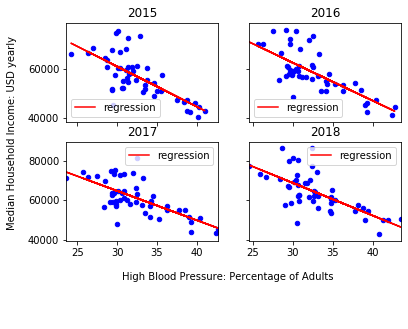

In [317]:
#High Blood Pressure
fig, ax = plt.subplots(nrows=2, ncols=2,sharex='col', sharey='row')
hbp_corr=[]

m=1
n=5
year=2015

for i in range(2):
    for j in range(2):
        (slope, intercept, rvalue, pvalue, stderr) = linregress(result_hbp.iloc[:,m], result_hbp.iloc[:,n])
        regress_values = pd.DataFrame(result_hbp.iloc[:,m].astype(float) * slope + intercept)
        line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
        result_hbp.plot(x=result_hbp.columns[m], y=result_hbp.columns[n], kind="scatter",ax=ax[i,j],c='b')
        prueba= pd.DataFrame(result_hbp.iloc[:,m])
        prueba['regression']=regress_values
        prueba.plot(x=prueba.columns[0],y=prueba.columns[1],ax=ax[i,j],c='r')
        plt.annotate(line_eq,(6,10),fontsize=15,color="red")
        correlation = st.pearsonr(result_hbp.iloc[:,m],result_hbp.iloc[:,n])
        hbp_corr.append([year,correlation]) 
        m+=1
        n+=1
        year+=1

        
#Put a general x_label and y_label
fig=ax[0,0].figure
fig.text(0.5,0, "High Blood Pressure: Percentage of Adults", ha="center", va="center")
fig.text(0,0.5, "Median Household Income: USD yearly", ha="center", va="center", rotation=90)

#Set labels
ax[0,0].set_title('2015')
ax[0,1].set_title('2016')
ax[1,1].set_title('2018')
ax[1,0].set_title('2017')


ax[0,0].set_ylabel(' ')
ax[1,1].set_xlabel(' ')
ax[1,0].set_ylabel(' ')
ax[1,0].set_xlabel(' ')

plt.savefig("Median Household Income vs High Blood Pressure.png")

hbp_corr

#plt.show()

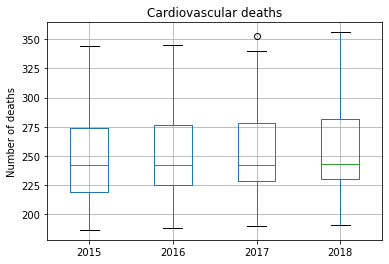

In [94]:
#Boxplot for each variable (5 boxplots in total)
#Pablo: Hay que ver como se le puede cambiar el color a cada año para que se vea más vistozo y se puedan diferenciar

#Cardiovascular deaths dataframe
c2_df.boxplot(column=[2015,2016,2017,2018])
plt.title("Cardiovascular deaths")
plt.ylabel("Number of deaths")
plt.savefig("Cardiovascular death boxplot.png")
plt.show()

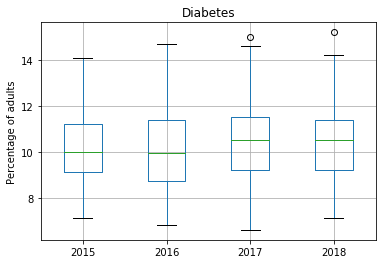

In [95]:
#Diabetes dataframe
d2_df.boxplot(column=[2015,2016,2017,2018])
plt.title("Diabetes")
plt.ylabel("Percentage of adults")
plt.savefig("Diabetes boxplot.png")
plt.show()

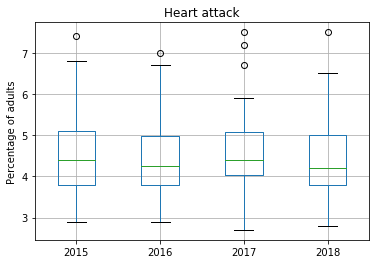

In [96]:
#Heart Attack dataframe
ha2_df.boxplot(column=[2015,2016,2017,2018])
plt.title("Heart attack")
plt.ylabel("Percentage of adults")
plt.savefig("Heart attack boxplot.png")
plt.show()

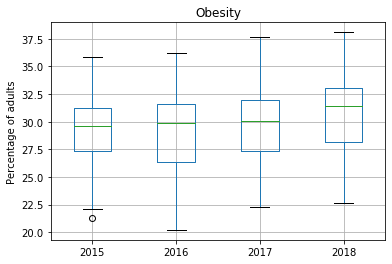

In [97]:
#Obesity dataframe
o2_df.boxplot(column=[2015,2016,2017,2018])
plt.title("Obesity")
plt.ylabel("Percentage of adults")
plt.savefig("Obesity boxplot.png")
plt.show()

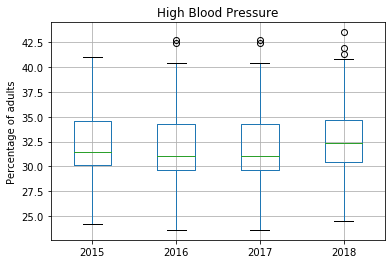

In [98]:
#High Blood Pressure
hbp2_df.boxplot(column=[2015,2016,2017,2018])
plt.title("High Blood Pressure")
plt.ylabel("Percentage of adults")
plt.savefig("High blood pressure boxplot.png")
plt.show()

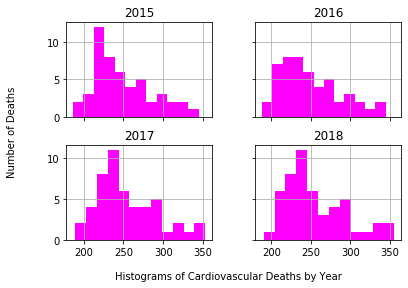

[[2015,
  NormaltestResult(statistic=4.748406337242653, pvalue=0.09308863561150406)],
 [2016,
  NormaltestResult(statistic=4.843112880762234, pvalue=0.08878332391396566)],
 [2017,
  NormaltestResult(statistic=5.735259234181871, pvalue=0.05683348415986465)],
 [2018,
  NormaltestResult(statistic=5.5714410850367635, pvalue=0.06168462661814414)]]

In [235]:
#Histogram for year of each variable

#Cardiovascular dataframe
fig, ax = plt.subplots(nrows=2, ncols=2,sharex='col', sharey='row')


normality_c=[]

m=1
year=2015

for i in range(2):
    for j in range(2):
        c2_df.hist(column = c2_df.columns[m], bins = 12, ax=ax[i,j], figsize=(20, 18),color='magenta')
        normality=st.normaltest(c2_df.iloc[:,m])
        normality_c.append([year,normality])
        m+=1
        year+=1

#Put a general x_label and y_label
fig=ax[0,0].figure
fig.text(0.5,0, "Histograms of Cardiovascular Deaths by Year", ha="center", va="center")
fig.text(0,0.5, "Number of Deaths", ha="center", va="center", rotation=90)

plt.savefig("Histogram Cardiovascular Deaths.png")

plt.show()

normality_c

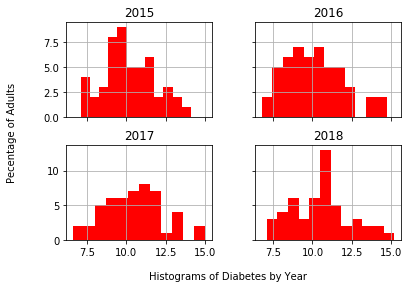

[[2015,
  NormaltestResult(statistic=0.7715197353959496, pvalue=0.6799337801420519)],
 [2016,
  NormaltestResult(statistic=2.0326984793402194, pvalue=0.3619137918166422)],
 [2017,
  NormaltestResult(statistic=0.7306622375385537, pvalue=0.6939668273888393)],
 [2018,
  NormaltestResult(statistic=1.0337970608071487, pvalue=0.596367297712923)]]

In [236]:
#Diabetes dataframe
fig, ax = plt.subplots(nrows=2, ncols=2,sharex='col', sharey='row')

normality_d=[]

m=1
year=2015

for i in range(2):
    for j in range(2):
        d2_df.hist(column = d2_df.columns[m], bins = 12, ax=ax[i,j], figsize=(20, 18),color='red')
        normality=st.normaltest(d2_df.iloc[:,m])
        normality_d.append([year,normality])
        m+=1
        year+=1

#Put a general x_label and y_label
fig=ax[0,0].figure
fig.text(0.5,0, "Histograms of Diabetes by Year", ha="center", va="center")
fig.text(0,0.5, "Pecentage of Adults", ha="center", va="center", rotation=90)

plt.savefig("Histogram Diabetes.png")

plt.show()

normality_d

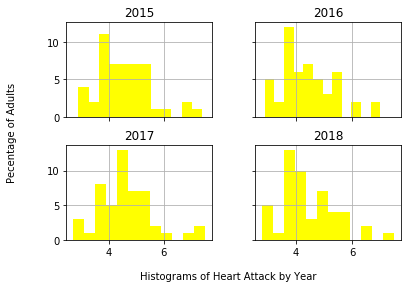

[[2015,
  NormaltestResult(statistic=6.642270456529248, pvalue=0.036111813324638434)],
 [2016,
  NormaltestResult(statistic=4.6150283534363945, pvalue=0.09950830442742062)],
 [2017,
  NormaltestResult(statistic=8.844466447430456, pvalue=0.012007387138556534)],
 [2018,
  NormaltestResult(statistic=5.738615141891795, pvalue=0.05673820015946185)]]

In [237]:
#Heart Attack dataframe
fig, ax = plt.subplots(nrows=2, ncols=2,sharex='col', sharey='row')

normality_ha=[]

m=1
year=2015

for i in range(2):
    for j in range(2):
        ha2_df.hist(column = ha2_df.columns[m], bins = 12, ax=ax[i,j], figsize=(20, 18),color='yellow')
        normality=st.normaltest(ha2_df.iloc[:,m])
        normality_ha.append([year,normality])
        m+=1
        year+=1

#Put a general x_label and y_label
fig=ax[0,0].figure
fig.text(0.5,0, "Histograms of Heart Attack by Year", ha="center", va="center")
fig.text(0,0.5, "Pecentage of Adults", ha="center", va="center", rotation=90)

plt.savefig("Histogram Heart Attack.png")

plt.show()

normality_ha

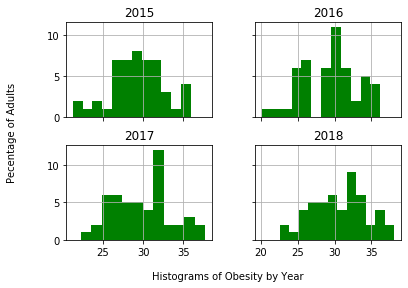

[[2015,
  NormaltestResult(statistic=0.5669907312879645, pvalue=0.7531466124815126)],
 [2016,
  NormaltestResult(statistic=0.9008605954051152, pvalue=0.6373538407149535)],
 [2017,
  NormaltestResult(statistic=0.629359237727112, pvalue=0.7300227223162107)],
 [2018,
  NormaltestResult(statistic=1.434142026004082, pvalue=0.4881800369441348)]]

In [238]:
#Obesity dataframe
fig, ax = plt.subplots(nrows=2, ncols=2,sharex='col', sharey='row')

normality_o=[]
year=2015

m=1
for i in range(2):
    for j in range(2):
        o2_df.hist(column = o2_df.columns[m], bins = 12, ax=ax[i,j], figsize=(20, 18),color='green')
        normality=st.normaltest(o2_df.iloc[:,m])
        normality_o.append([year,normality])
        m+=1
        year+=1

#Put a general x_label and y_label
fig=ax[0,0].figure
fig.text(0.5,0, "Histograms of Obesity by Year", ha="center", va="center")
fig.text(0,0.5, "Pecentage of Adults", ha="center", va="center", rotation=90)

plt.savefig("Histogram Obesity.png")

plt.show()

normality_o

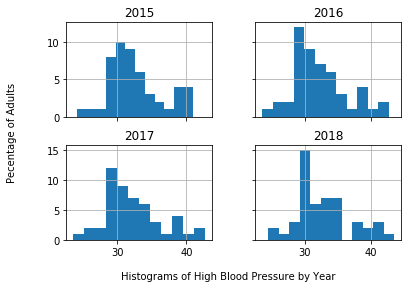

[[2015,
  NormaltestResult(statistic=2.5994417128889586, pvalue=0.27260787914669243)],
 [2016,
  NormaltestResult(statistic=4.53639914583729, pvalue=0.10349835367565385)],
 [2017,
  NormaltestResult(statistic=4.53639914583729, pvalue=0.10349835367565385)],
 [2018,
  NormaltestResult(statistic=4.77301816848095, pvalue=0.0919501143574891)]]

In [239]:
#High Blood Pressure
fig, ax = plt.subplots(nrows=2, ncols=2,sharex='col', sharey='row')

normality_hbp=[]

m=1
year=2015

for i in range(2):
    for j in range(2):
        hbp2_df.hist(column = hbp2_df.columns[m], bins = 12, ax=ax[i,j], figsize=(20, 18))
        normality=st.normaltest(hbp2_df.iloc[:,m])
        normality_hbp.append([year,normality])
        m+=1
        year+=1

#Put a general x_label and y_label
fig=ax[0,0].figure
fig.text(0.5,0, "Histograms of High Blood Pressure by Year", ha="center", va="center")
fig.text(0,0.5, "Pecentage of Adults", ha="center", va="center", rotation=90)

plt.savefig("Histogram High Blood Pressure.png")

plt.show()

normality_hbp

In [241]:
#Diabetes vs Obesity
result_d_o= pd.merge(d2_df,o2_df, how='left', on='State')
#result_hbp.head()

#Heart attack vs Obesity
result_ha_o= pd.merge(ha2_df,o2_df, how='left', on='State')
#result_hbp.head()

#High blood pressure vs Obesity
result_hbp_o= pd.merge(hbp2_df,o2_df, how='left', on='State')
#result_hbp_o.head()

Edition,State,2015_x,2016_x,2017_x,2018_x,2015_y,2016_y,2017_y,2018_y
0,Alabama,40.3,40.4,40.4,41.9,33.5,35.6,35.7,36.3
1,Alaska,29.8,27.5,27.5,31.8,29.7,29.8,31.4,34.2
2,Arizona,30.7,30.8,30.8,30.7,28.9,28.4,29.0,29.5
3,Arkansas,38.7,39.3,39.3,41.3,35.9,34.5,35.7,35.0
4,California,28.7,28.5,28.5,28.4,24.7,24.2,25.0,25.1


[[2015, (0.6551918017153725, 2.4323132175871067e-07)],
 [2016, (0.7540423942926036, 2.5876352131827853e-10)],
 [2017, (0.6936284601713112, 2.34747481857552e-08)],
 [2018, (0.6607947301753127, 1.766403683177738e-07)]]

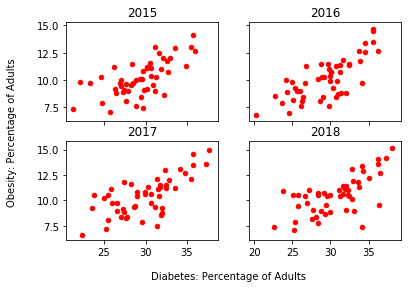

In [320]:
#Scatterplots of Obesity vs Heart Attack, Diabetes and High Blood Pressure
#Diabetes vs Obesity
fig, ax = plt.subplots(nrows=2, ncols=2,sharex='col', sharey='row')
d_o_corr=[]

m=1
n=5
year=2015

for i in range(2):
    for j in range(2):
        result_d_o.plot(x=result_d_o.columns[n], y=result_d_o.columns[m], kind="scatter", ax=ax[i,j],c='r')
        correlation = st.pearsonr(result_d_o.iloc[:,m],result_d_o.iloc[:,n])
        d_o_corr.append([year,correlation])
        m+=1
        n+=1
        year+=1
         
#Put a general x_label and y_label
fig=ax[0,0].figure
fig.text(0.5,0, "Diabetes: Percentage of Adults", ha="center", va="center")
fig.text(0,0.5, "Obesity: Percentage of Adults", ha="center", va="center", rotation=90)

#Set labels
ax[0,0].set_title('2015')
ax[0,1].set_title('2016')
ax[1,1].set_title('2018')
ax[1,0].set_title('2017')


ax[0,0].set_ylabel(' ')
ax[1,1].set_xlabel(' ')
ax[1,0].set_ylabel(' ')
ax[1,0].set_xlabel(' ')

plt.savefig("Diabetes vs Obsesity.png")

d_o_corr

#plt.show()

[[2015, (0.6605046720797495, 1.7961951681754726e-07)],
 [2016, (0.7147036927252935, 5.554041999897177e-09)],
 [2017, (0.6741590940343671, 8.010618460516433e-08)],
 [2018, (0.6461250677538088, 4.0257223131935607e-07)]]

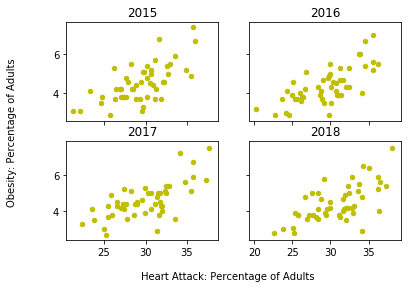

In [318]:
#Heart Attack vs Obesity
fig, ax = plt.subplots(nrows=2, ncols=2,sharex='col', sharey='row')
ha_o_corr=[]

m=1
n=5
year=2015

for i in range(2):
    for j in range(2):
        result_ha_o.plot(x=result_ha_o.columns[n], y=result_ha_o.columns[m], kind="scatter", ax=ax[i,j],c='y')
        correlation = st.pearsonr(result_ha_o.iloc[:,m],result_ha_o.iloc[:,n])
        ha_o_corr.append([year,correlation])
        m+=1
        n+=1
        year+=1
         
#Put a general x_label and y_label
fig=ax[0,0].figure
fig.text(0.5,0, "Heart Attack: Percentage of Adults", ha="center", va="center")
fig.text(0,0.5, "Obesity: Percentage of Adults", ha="center", va="center", rotation=90)

#Set labels
ax[0,0].set_title('2015')
ax[0,1].set_title('2016')
ax[1,1].set_title('2018')
ax[1,0].set_title('2017')


ax[0,0].set_ylabel(' ')
ax[1,1].set_xlabel(' ')
ax[1,0].set_ylabel(' ')
ax[1,0].set_xlabel(' ')

plt.savefig("Heart Attack vs Obsesity.png")

ha_o_corr

#plt.show()

[[2015, (0.7386310096968427, 9.177802430245822e-10)],
 [2016, (0.7460734601439876, 5.036136834787738e-10)],
 [2017, (0.7773851313433111, 3.154709650338387e-11)],
 [2018, (0.7708375436803945, 5.835491180513047e-11)]]

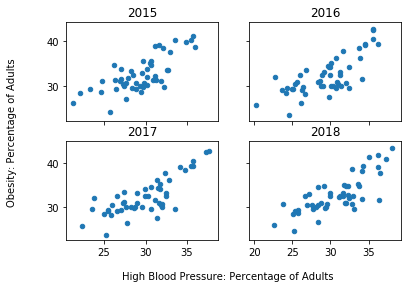

In [319]:
#Hight Blood Pressure vs Obesity
fig, ax = plt.subplots(nrows=2, ncols=2,sharex='col', sharey='row')
hbp_o_corr=[]

m=1
n=5
year=2015

for i in range(2):
    for j in range(2):
        result_hbp_o.plot(x=result_hbp_o.columns[n], y=result_hbp_o.columns[m], kind="scatter", ax=ax[i,j])
        correlation = st.pearsonr(result_hbp_o.iloc[:,m],result_hbp_o.iloc[:,n])
        hbp_o_corr.append([year,correlation])
        m+=1
        n+=1
        year+=1
         
#Put a general x_label and y_label
fig=ax[0,0].figure
fig.text(0.5,0, "High Blood Pressure: Percentage of Adults", ha="center", va="center")
fig.text(0,0.5, "Obesity: Percentage of Adults", ha="center", va="center", rotation=90)

#Set labels
ax[0,0].set_title('2015')
ax[0,1].set_title('2016')
ax[1,1].set_title('2018')
ax[1,0].set_title('2017')


ax[0,0].set_ylabel(' ')
ax[1,1].set_xlabel(' ')
ax[1,0].set_ylabel(' ')
ax[1,0].set_xlabel(' ')

plt.savefig("High Blood Pressure vs Obsesity.png")

hbp_o_corr

#plt.show()